# Data collection

Running VASP phonon calculation: Linear response method.
Using phonon package in python generate FORCE_SETS and phonon.yaml file.

code present in phonon.py

In [ ]:

import os
import csv
import re
from scipy.interpolate import interp1d
import numpy as np
import torch

#generate phonon dos frequency data within the specified range, padding.
def data_generate(r, s):
    mpid_dos = {}
    file_dir = ["1112", "1114", "1116", "to_zeb_1108","0_83"]
    for file_dir_ in file_dir:
        for d in os.listdir(file_dir_):
            if d.endswith(".yaml"):
                with open(os.path.join(file_dir_, d)) as file:
                    data = csv.reader(file)
                    next(data)
                    freq = []
                    inte = []
                    for row in data:
                        freq.append(float(re.findall(r"\s(-?\d+\.?/?\d*%?)", row[0])[0]))
                        inte.append(float(re.findall(r"\s(-?\d+\.?/?\d*%?)", row[0])[1]))
                    if max(freq) <= r[1]:
                        x = freq + [r[1]]
                        y = inte + [r[0]]
                    else:
                        x = freq
                        y = inte
                    f = interp1d(x, y)
                    newx = np.linspace(r[0], r[1], s)
                    newy = f(newx)
                    mpid_dos[d.split("_")[1]] = {"dos" : list(newy), "tcd" : 0}
#mark the thermal conductivity value
    for d in os.listdir("msgpack_data_scs/msgpack_data/"):
        with open(f"msgpack_data_scs/msgpack_data/{d}", "rb") as p:
            mpd = msgpack.unpack(p)
            freq = mpd['frequency_points']
            inte = mpd['total_dos']
            if max(freq) <= r[1]:
                x = freq + [r[1]]
                y = inte + [r[0]]
            else:
                x = freq
                y = inte
            f = interp1d(x, y)
            newx = np.linspace(r[0], r[1], s)
            newy = f(newx)
            mpid_dos[d.split(".")[0]] = {"dos" : list(newy), "tcd" : 0}
    mpid = {}
    with open("new_set_tcd.csv", "r") as csvfile:
        spamreader = csv.reader(csvfile)
        next(spamreader)
        for row in spamreader:
            if row[1] != '':
                if row[3] == '':
                    mpid[row[2]] = float(row[1])
                elif ( float(row[3]) >= 200 ) and ( float(row[3]) <=400 ):
                    mpid[row[2]] = float(row[1])
    mpid.pop("")
    #print(mpid_dos.keys())
    total_data = []
    for i in mpid.keys():
        try:
            tcd = mpid[i]
            data = mpid_dos[i]["dos"] + [tcd]
            total_data.append(data)
            #print(len(data))
        except:
            continue
    total_dos = torch.tensor(total_data, dtype = torch.float32)
    torch.save(total_dos, f"dos_{r[0]}-{r[1]}hz_{s}d_299.pt")

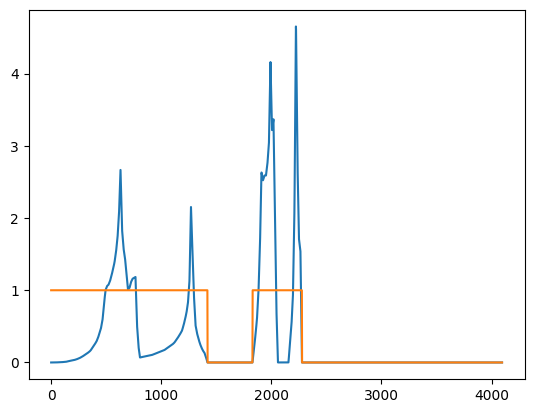

In [4]:
#show the mask after padding the data
import torch
import matplotlib.pyplot as plt
dos = torch.load("dos_0-18hz_4096d_299.pt")
mask = dos[1,:-1].to(bool).to(torch.float32)
plt.plot(dos[1,:-1])
plt.plot(mask)

All calculate phonon dos with material project id.
Experment thermal conductivity form SpringerMaterials showed in new_set_tcd.csv

In [16]:
import msgpack
with open("mpid_dos_2.msgpack", "rb") as f:
    data = msgpack.unpack(f)

In [17]:
data.keys()

dict_keys(['mp-997182', 'mp-3839', 'mp-1156', 'mp-5986', 'mp-612118', 'mp-554310', 'mp-5213', 'mp-2883', 'mp-1192133', 'mp-4840', 'mp-111', 'mp-11836', 'mp-8016', 'mp-2343', 'mp-3614', 'mp-66', 'mp-17114', 'mp-3829', 'mp-1', 'mp-540872', 'mp-6030', 'mp-131', 'mp-1191202', 'mp-160', 'mp-5163', 'mp-3688', 'mp-19833', 'mp-607450', 'mp-5229', 'mp-104', 'mp-1201600', 'mp-4602', 'mp-5782', 'mp-540912', 'mp-757388', 'mp-1317', 'mp-4573', 'mp-27910', 'mp-569571', 'mp-24504', 'mp-20012', 'mp-1196533', 'mp-604245', 'mp-14092', 'mp-82', 'mp-17544', 'mp-730', 'mp-557560', 'mp-23158', 'mp-4008', 'mp-3019', 'mp-9919', 'mp-30133', 'mp-3595', 'mp-4979', 'mp-2730', 'mp-1206717', 'mp-1189811', 'mp-5874', 'mp-20305', 'mp-2961', 'mp-29666', 'mp-6280', 'mp-6179', 'mp-23156', 'mp-4473', 'mp-542903', 'mp-19802', 'mp-23959', 'mp-1079574', 'mp-4820', 'mp-29644', 'mp-4524', 'mp-2176', 'mp-4953', 'mp-4086', 'mp-22137', 'mp-2908', 'mp-567525', 'mp-984', 'mp-647813', 'mp-696752', 'mp-23116', 'mp-8017', 'mp-2469', 

In [20]:
data["mp-997182"].keys()

dict_keys(['dos', 'tcd'])

# Regress Model

modell : NN Highway model

python3 train_regress_model.py -c config-regress.yaml

In [9]:
from regress_model import nn_model

model = nn_model.NNModel(4096)

checkpoint = torch.load("20241226_165431_NNModel/model_best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

NNModel(
  (l1): Linear(in_features=4096, out_features=1024, bias=True)
  (h1): Highway(
    (elu): ReLU()
    (proj): Linear(in_features=1024, out_features=1024, bias=True)
    (transform): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (h2): Highway(
    (elu): ReLU()
    (proj): Linear(in_features=1024, out_features=1024, bias=True)
    (transform): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (h3): Highway(
    (elu): ReLU()
    (proj): Linear(in_features=1024, out_features=1024, bias=True)
    (transform): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (h4): Highway(
    (elu): ReLU()
    (proj): Linear(in_features=1024, out_features=1024, bias=True)
    (transform): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=256, bias=True)
  (l4): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Text(0, 0.5, 'real')

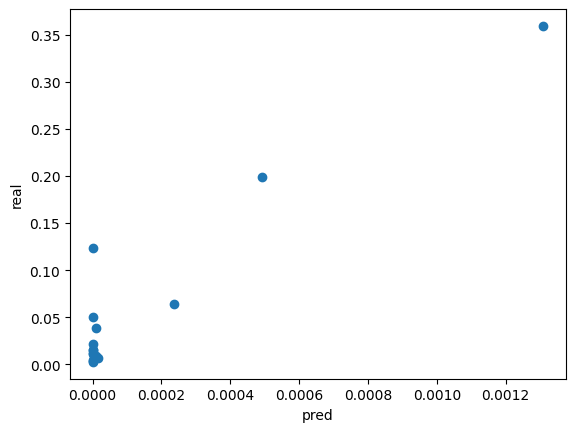

In [10]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
class MyDataset(Dataset):
    def __init__(self, datadic):
        self.data = torch.load(datadic)
        self.norm = torch.norm(self.data[:,-1])
    def __getitem__(self, idx):
        tcd = self.data[idx, -1]
        dos = self.data[idx,:-1]
        return dos, tcd / self.norm
    
    def __len__(self):
        return self.data.size()[0]

d = MyDataset("dos_0-18hz_4096d_299.pt")
dos , tcd = d[:16]
plt.scatter(model(dos).detach().numpy(), tcd.numpy())
plt.xlabel("pred")
plt.ylabel("real")

# classify model

In [2]:
#SpectrumDavit Model
import torch
from spectrumdavit_model import SpectrumDaVit
model =SpectrumDaVit(
                    in_chans=1,
                    num_classes=2,
                    depths=(1,1),
                    embed_dims=(192,96),
                    num_heads=(6,3),
                    window_size=70,
)

checkpoint = torch.load("20241226_141001_SpectrumDaVit/model_best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

SpectrumDaVit(
  (stem): Stem(
    (conv): Conv1d(1, 192, kernel_size=(7,), stride=(4,), padding=(3,))
    (norm): Norm1d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): DaVitStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): Sequential(
          (0): SpatialBlock(
            (cpe1): ConvPosEnc1d(
              (proj): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(1,), groups=192)
              (act): Identity()
            )
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (cpe2): ConvPosEnc1d(
              (proj): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(1,), groups=192)
             

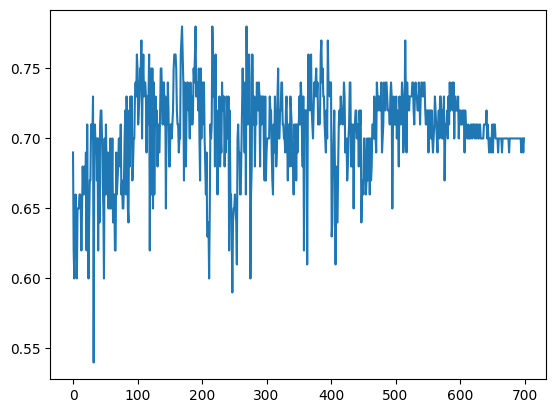

In [6]:
#SpectrumDavit Model
import re
with open("20241226_141001_SpectrumDaVit/SpectrumDaVit.log") as f:
    log = f.readlines()
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for line in log:
    tl = re.search("Train Loss.: ([0-9]*\.[0-9]*)", line)
    vl = re.search("Validation Loss.: ([0-9]*\.[0-9]*)", line)
    tr = re.search("Train Acc.: (-?[0-9]*\.[0-9]*)", line)
    vr = re.search("Validation Acc.: (-?[0-9]*\.[0-9]*)", line)
    if tl:
        train_loss.append(float(tl.group(1)))
        valid_loss.append(float(vl.group(1)))
        train_acc.append(float(tr.group(1)))
        valid_acc.append(float(vr.group(1)))
import matplotlib.pyplot as plt
plt.plot(valid_acc[300:])

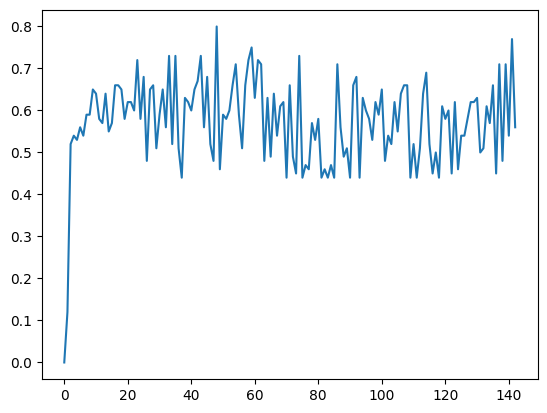

In [9]:
#doscef Model
import re
with open("20241226_140345_DosCefConv/DosCefConv.log") as f:
    log = f.readlines()
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for line in log:
    tl = re.search("Train Loss.: ([0-9]*\.[0-9]*)", line)
    vl = re.search("Validation Loss.: ([0-9]*\.[0-9]*)", line)
    tr = re.search("Train Acc.: (-?[0-9]*\.[0-9]*)", line)
    vr = re.search("Validation Acc.: (-?[0-9]*\.[0-9]*)", line)
    if tl:
        train_loss.append(float(tl.group(1)))
        valid_loss.append(float(vl.group(1)))
        train_acc.append(float(tr.group(1)))
        valid_acc.append(float(vr.group(1)))
import matplotlib.pyplot as plt
plt.plot(valid_acc)

# classify model with masking

In [11]:
#attn_doscef Model with masking
from attn_doscefmodel_classify import AttentionDos
model = AttentionDos(in_chs = 1, num_classes = 2)

checkpoint = torch.load("20250103_154000_AttentionDos/model_best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

AttentionDos(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv1d(1, 48, kernel_size=(3,), stride=(2,))
      (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): GELU(approximate='none')
    )
    (conv2): ConvNormAct(
      (conv): Conv1d(48, 96, kernel_size=(3,), stride=(2,))
      (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): GELU(approximate='none')
    )
  )
  (stages): Sequential(
    (0): AttentionStage(
      (ds): Identity()
      (blocks): Sequential(
        (0): SpatialAttentionBlock(
          (ls1): LayerScale1d()
          (drop_path1): DropPath()
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (fc2): Linear(in_features=384, out_features=96

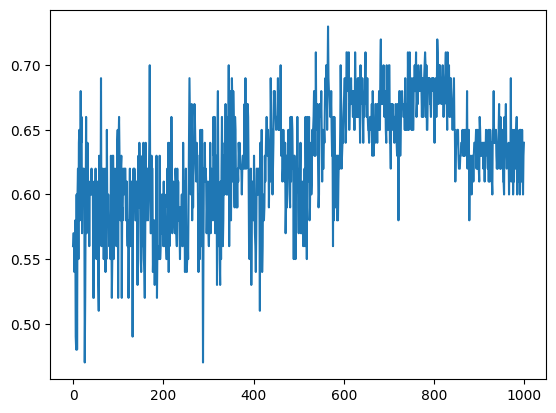

In [12]:
import re
with open("20250103_154000_AttentionDos/AttentionDos.log") as f:
    log = f.readlines()
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for line in log:
    tl = re.search("Train Loss.: ([0-9]*\.[0-9]*)", line)
    vl = re.search("Validation Loss.: ([0-9]*\.[0-9]*)", line)
    tr = re.search("Train Acc.: (-?[0-9]*\.[0-9]*)", line)
    vr = re.search("Validation Acc.: (-?[0-9]*\.[0-9]*)", line)
    if tl:
        train_loss.append(float(tl.group(1)))
        valid_loss.append(float(vl.group(1)))
        train_acc.append(float(tr.group(1)))
        valid_acc.append(float(vr.group(1)))
import matplotlib.pyplot as plt
plt.plot(valid_acc)